In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import pandas as pd

def clean_data(df):
    """Clean and preprocess the DataFrame."""

    # تحديد الأعمدة الرقمية والاسمية
    numeric_cols = ['Time_spent_Alone', 'Social_event_attendance', 'Going_outside', 'Friends_circle_size', 'Post_frequency']
    categorical_cols = ['Stage_fear', 'Drained_after_socializing']

    # 1. إزالة القيم المكررة
    df = df.drop_duplicates()

    # 2. تحويل النصوص إلى lowercase (للتناسق)
    for col in categorical_cols:
        df[col] = df[col].astype(str).str.lower().str.strip()
        df[col] = df[col].map({'yes': 1, 'no': 0})


    # 3. ملء القيم المفقودة
    imputer_numeric = SimpleImputer(strategy='median')
    imputer_categorical = SimpleImputer(strategy='most_frequent')

    df[numeric_cols] = imputer_numeric.fit_transform(df[numeric_cols])
    df[categorical_cols] = imputer_categorical.fit_transform(df[categorical_cols])

    # 4. قص القيم الشاذة
    df['Time_spent_Alone'] = df['Time_spent_Alone'].clip(upper=8.5)
    df['Friends_circle_size'] = df['Friends_circle_size'].clip(upper=15)

    # 5. حذف عمود id إن وُجد
    if 'id' in df.columns:
        df = df.drop('id', axis=1)

    # 6. التأكد من أنواع البيانات
    df[numeric_cols] = df[numeric_cols].astype(float)
    df[categorical_cols] = df[categorical_cols].astype(int)

    return df, numeric_cols, categorical_cols


# Load the training data
train_df = pd.read_csv("train.csv")
train_df_cleaned, numeric_cols, categorical_cols = clean_data(train_df.copy())

# Define X and y
X = train_df_cleaned[numeric_cols + categorical_cols]
y = train_df_cleaned['Personality'].map({'Extrovert': 1, 'Introvert': 0})

# Load and clean the test data
test_df = pd.read_csv("test.csv")
test_ids = test_df['id']
test_df_cleaned, _, _ = clean_data(test_df.copy())

# Reorder columns of test data to match training data
test_df_cleaned = test_df_cleaned[X.columns]

# Define and fit the scaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Scale the test data
X_test_scaled = scaler.transform(test_df_cleaned)

In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np


# Define the models
# Assuming X_scaled and y are already defined and scaled from the training data
rf_model = RandomForestClassifier(n_estimators=200, max_depth=20, min_samples_split=5, min_samples_leaf=2, random_state=42)
gb_model = GradientBoostingClassifier(random_state=42)

# Train the models
rf_model.fit(X_scaled, y)
gb_model.fit(X_scaled, y)

# Create a VotingClassifier
voting_clf = VotingClassifier(
    estimators=[('rf', rf_model), ('gb', gb_model)],
    voting='soft'
)
voting_clf.fit(X_scaled, y)

# Make predictions on the scaled test data
predictions = voting_clf.predict(X_test_scaled)

# Create a submission file
submission_df = pd.DataFrame({'id': test_ids, 'Personality': predictions})
submission_df['Personality'] = submission_df['Personality'].map({1: 'Extrovert', 0: 'Introvert'})
submission_df.to_csv('submission.csv', index=False)

print("Submission file created successfully!")
display(submission_df.head())

Submission file created successfully!


,id,Personality
0,18524,Extrovert
1,18525,Introvert
2,18526,Extrovert
3,18527,Extrovert
4,18528,Introvert


Accuracy: 0.9900

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        29
           1       0.99      1.00      0.99        71

    accuracy                           0.99       100
   macro avg       0.99      0.98      0.99       100
weighted avg       0.99      0.99      0.99       100


Confusion Matrix:


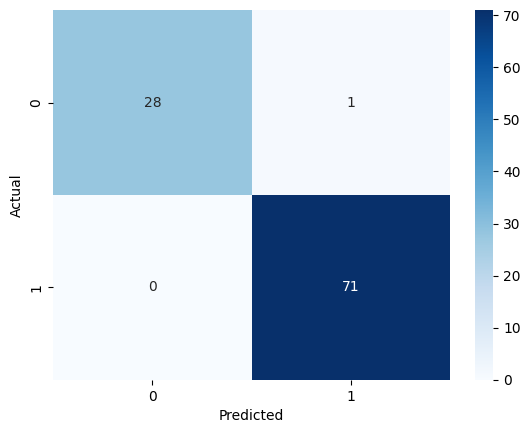

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=100, random_state=42)

# Train the VotingClassifier on the training data
voting_clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = voting_clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


New Accuracy: 0.9900

New Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        29
           1       0.99      1.00      0.99        71

    accuracy                           0.99       100
   macro avg       0.99      0.98      0.99       100
weighted avg       0.99      0.99      0.99       100


New Confusion Matrix:


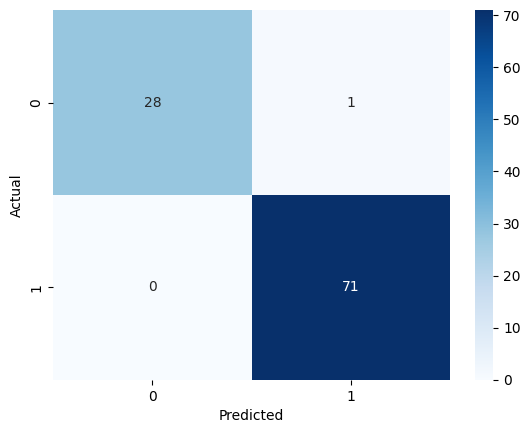

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define the models
rf_model = RandomForestClassifier(n_estimators=200, max_depth=20, min_samples_split=5, min_samples_leaf=2, random_state=42)
gb_model = GradientBoostingClassifier(random_state=42)

# Define the parameter distribution for RandomForestClassifier
# param_dist_rf = {
#     'n_estimators': [100, 200, 300, 400, 500],
#     'max_depth': [10, 20, 30, 40, 50, None],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'bootstrap': [True, False]
# }

# Create a RandomizedSearchCV object for RandomForestClassifier
# random_search_rf = RandomizedSearchCV(estimator=rf_model, param_distributions=param_dist_rf, n_iter=5, cv=2, n_jobs=-1, verbose=2, random_state=42)

# Fit the random search to the data
# random_search_rf.fit(X_scaled, y)

# Print the best parameters for RandomForestClassifier
# print("Best parameters for RandomForestClassifier: ", random_search_rf.best_params_)

# Define the parameter distribution for GradientBoostingClassifier
# param_dist_gb = {
#     'n_estimators': [100, 200, 300, 400, 500],
#     'learning_rate': [0.01, 0.05, 0.1, 0.2],
#     'max_depth': [3, 5, 7, 9],
#     'subsample': [0.8, 0.9, 1.0]
# }

# Create a RandomizedSearchCV object for GradientBoostingClassifier
# random_search_gb = RandomizedSearchCV(estimator=gb_model, param_distributions=param_dist_gb, n_iter=5, cv=2, n_jobs=-1, verbose=2, random_state=42)

# Fit the random search to the data
# random_search_gb.fit(X_scaled, y)

# Print the best parameters for GradientBoostingClassifier
# print("Best parameters for GradientBoostingClassifier: ", random_search_gb.best_params_)

# Create new models with the best parameters
best_rf_model = RandomForestClassifier(n_estimators=100, min_samples_split=2, min_samples_leaf=4, max_depth=40, bootstrap=False, random_state=42)
best_gb_model = GradientBoostingClassifier(subsample=0.8, n_estimators=300, max_depth=3, learning_rate=0.01, random_state=42)

# Create a new VotingClassifier with the best models
best_voting_clf = VotingClassifier(
    estimators=[('rf', best_rf_model), ('gb', best_gb_model)],
    voting='soft'
)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=100, random_state=42)

# Train the new VotingClassifier on the training data
best_voting_clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred_best = best_voting_clf.predict(X_test)

# Evaluate the new model
accuracy_best = accuracy_score(y_test, y_pred_best)
print(f"\nNew Accuracy: {accuracy_best:.4f}")

print("\nNew Classification Report:")
print(classification_report(y_test, y_pred_best))

print("\nNew Confusion Matrix:")
cm_best = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
# Make predictions on the scaled test data
predictions_best = best_voting_clf.predict(X_test_scaled)

# Create a new submission file
submission_df_best = pd.DataFrame({'id': test_ids, 'Personality': predictions_best})
submission_df_best['Personality'] = submission_df_best['Personality'].map({1: 'Extrovert', 0: 'Introvert'})
submission_df_best.to_csv('submission.csv', index=False)

print("New submission file created successfully!")
display(submission_df_best.head())

New submission file created successfully!


,id,Personality
0,18524,Extrovert
1,18525,Introvert
2,18526,Extrovert
3,18527,Extrovert
4,18528,Introvert
